# DMOZ weighting methods using Global Recall & Jaccard


In [1]:
# testing - para mostrar calculos intermedios
debug = True
testing = False

Dataset load and pre-processing

In [2]:
print(':::::::::::::::: Loaded topic_names ::::::::::::::::')

import pandas as pd
import io
df_topics = pd.read_csv (r'topic_names_25.txt', header = None, delimiter = '\t', dtype={'topic_number': "Int64", 'topic_name': str})
df_topics.columns = ['topic_number','topic_name']
df_topics

:::::::::::::::: Loaded topic_names ::::::::::::::::


,topic_number,topic_name
0,1,Top/Science/Math/Number_Theory
1,25,Top/Sports/Golf/Instruction
2,37,Top/Business/Industrial_Goods_and_Services/Fac...
3,58,Top/Society/Issues/Environment
4,99,Top/Games/Board_Games/War_and_Politics
5,134,Top/Home/Cooking/Fruits_and_Vegetables
6,187,Top/Sports/Cycling/Travel
7,215,Top/Recreation/Pets/Exotic
8,221,Top/Recreation/Outdoors/Camping
9,259,Top/Business/Investing/News_and_Media


In [3]:
if debug:
  select_name = df_topics.loc[df_topics['topic_number'] == 528]
  print(select_name)


    topic_number                                         topic_name
18           528  Top/Business/Agriculture_and_Forestry/Aquaculture


### Dictionary
dict_topic_numb_name={topic_number: topic_name}


In [4]:
df1 = df_topics[['topic_name']].to_numpy()
list_of_topic_names = []
for arr in df1:
  for topic in arr:  
    list_of_topic_names.append(topic)
print(list_of_topic_names)



### Dictionary of {topic_number: topic_name} 
dict_topic_numb_name = df_topics.set_index('topic_number').T.to_dict()
print("\n",dict_topic_numb_name[1], dict_topic_numb_name[528])

['Top/Science/Math/Number_Theory', 'Top/Sports/Golf/Instruction', 'Top/Business/Industrial_Goods_and_Services/Factory_Automation', 'Top/Society/Issues/Environment', 'Top/Games/Board_Games/War_and_Politics', 'Top/Home/Cooking/Fruits_and_Vegetables', 'Top/Sports/Cycling/Travel', 'Top/Recreation/Pets/Exotic', 'Top/Recreation/Outdoors/Camping', 'Top/Business/Investing/News_and_Media', 'Top/Health/Conditions_and_Diseases/Skin_Disorders', 'Top/Health/Reproductive_Health/Birth_Control', 'Top/Science/Environment/Air_Quality', 'Top/Science/Social_Sciences/Economics', 'Top/Business/Hospitality/Restaurant_Chains', 'Top/Shopping/Tobacco/Cigars', 'Top/Shopping/Jewelry/Theme', 'Top/Arts/Music/Collecting', 'Top/Business/Agriculture_and_Forestry/Aquaculture', 'Top/Science/Astronomy/Solar_System', 'Top/Recreation/Birding/Europe', 'Top/Society/Religion_and_Spirituality/Pagan', 'Top/Business/Management/Management_Science', 'Top/Arts/Music/Reviews', 'Top/Arts/Television/Networks']

 {'topic_name': 'Top/Sc

### Test Spacy

In [5]:
!pip install -U pip setuptools wheel
!pip install -U spacy
#!python -m spacy download en_core_web_sm


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [6]:
!python -m spacy download en_core_web_sm

2023-02-10 11:37:35.838335: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-10 11:37:35.838368: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-10 11:37:37.001378: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-10 11:37:37.001409: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-10 11:37:37.001427: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyterhub): /proc/driver/nvidia/version does not exist
Defaulting to user installation because normal site-packages is no

### Clase Texto (Documento)


In [7]:
from collections import defaultdict
import spacy
import numpy as np

def valid_token(token):
    return not token.is_stop and token.is_alpha and token.lemma_.isalnum()

class Texto(object):
    nlp = spacy.load('en_core_web_sm')

    #categorias = df_topics[['topic_name']].to_numpy()  
    # convert to an array of DMOZ topic names, named categorias
    
    # df1 = df_topics[['topic_name']].to_numpy()
    # categorias = []
    # for arr in df1:
    #   for topic in arr:  
    #    categorias.append(topic)
    # print(categorias)               # pero tmb tengo dictionary de topic NUM: categoria!!!!!!!!!!!!!!!!!!! ver si no esta de mas esto

    
    def __init__(self, idx, path, spacy_doc=False):
        self.idx = idx 
        self.path = path
        self.topic_number = int(path.split('/')[-2])
        self.raw_text = open(path, 'r', encoding='UTF-8').read().lower()           # str.lower() added by Ceci
        # all the tokens in the doc, no filtering        
        self.tokens = Texto.nlp(self.raw_text) 
        #self.tokens = Texto.nlp(self.raw_text, disable=['textcat','ner','tagger','parser'])         

    # si category_idx no es None, entonces devuelve un array de 0s y 1s.
    # 1s en las posiciones donde hay un texto en textos tal que el nro de topico es category_idx.
    # si category_idx=None entonces devuelve un array con nros de topicos para cada texto (este array no es de 0s y 1s)
    # category_idx DEBE ser ENTERO
    @staticmethod
    def target(textos, category_idx=None):        
        if not category_idx is None:                    
            #categoria = dict_topic_numb_name[Texto.topic_number]  # esto me da el nombre del topic            
#             if debug:
#               for texto in textos:
#                 print(texto.topic_number, category_idx, int(texto.topic_number)==int(category_idx))
#                 print(dict_topic_numb_name[int(texto.topic_number)])  # esto me da el nombre del topic            
            target = np.array([int(texto.topic_number)==int(category_idx) for texto in textos])
            # devuelve 1s donde hay doc para ese topico
            return target[:,np.newaxis] # devuelve un arreglo de 0s y 1s con 1s si el doc es del topico category_idx
        else:      
            # el index deberia ser le nro de topico del DF de topic names, no el indice, no?
            #categoria2index = dict([(categoria, index) for index,categoria in enumerate(Texto.categorias)])
            #print("categoria2index", categoria2index)
            target = np.array([int(texto.topic_number) for texto in textos])  # devuelve un arreglo de TOPIC_IDs segun documentos en textos (IDS pueden ser distintos)
            return target[:,np.newaxis]
        
print('[  OK   ] Texto Class loaded.')


[  OK   ] Texto Class loaded.


## load files from disk



In [8]:
import os

if not (os.path.isfile('pickle_texts/dmoz_train_25.p') and os.path.isfile('pickle_texts/dmoz_test_25.p')):

    !cp '/set12_train_25topics.tar.gz' .
    #unzip dataset
    !tar xzf 'set12_train_25topics.tar.gz'

    print(':::::::::::::::: EXTRACTED dataset Set12 ::::::::::::::::')

    !cp '/set3_test_all_topics.tar.gz' .
    #unzip dataset
    !tar xzf 'set3_test_all_topics.tar.gz'

    print(':::::::::::::::: Extracted dataset Set3 ::::::::::::::::')
else:
        print("Files exist. Nothing to extract")
    
    
    
   

Files exist. Nothing to extract



## Load Train & Test from pickles

In [9]:
import pickle
import os

#!mkdir -p db/cache
if not (os.path.isfile('pickle_texts/dmoz_train_25.p')):
    
    !mkdir -p 'pickle_texts'
    print('[ INFO  ] Reading raw text and transforming it into object Texto.')

    #path_train = 'set12_train_3_topics/'
    path_train = 'set12_train'


    idx = 0
    train = []
    for dirpath,_,filenames in os.walk(path_train):
        print("topic: ", dirpath)
        for filename in filenames:
              train.append(Texto(idx, os.path.join(dirpath, filename)))
              idx += 1
              print(filename)
    pickle.dump(train, open('pickle_texts/dmoz_train_25.p','wb'))
    print('[ INFO  ] Save train set into pickles')
    print('train set size: {}'.format(len(train)))
    
else:
    print('[ INFO  ] Retrieve train set from pickles')    
    train = pickle.load(open('pickle_texts/dmoz_train_25.p', 'rb'))    
    


if not (os.path.isfile('pickle_texts/dmoz_test_25.p')):    
    idx = 0
    test = []
    #path_test = 'set3_test_3_topics/'
    path_test = 'set3_test'
    for dirpath,_,filenames in os.walk(path_test):
        print("topic: ", dirpath)
        for filename in filenames:
            test.append(Texto(idx, os.path.join(dirpath, filename)))
            idx += 1
    pickle.dump(test, open('pickle_texts/dmoz_test_25.p','wb'))
    print('[ INFO  ] Save test set into pickles')
    print('test set size:  {}'.format(len(test)))
    
else:
    print('[ INFO  ] Retrieve test set from pickles')    
    test = pickle.load(open('pickle_texts/dmoz_test_25.p', 'rb'))
    
print('[  OK   ] train/test sets loaded.')


[ INFO  ] Retrieve train set from pickles
[ INFO  ] Retrieve test set from pickles
[  OK   ] train/test sets loaded.


# Matrix and vocabulary building


**Trigrams**

In [10]:
from collections import defaultdict

def valid_token(token):
    return not token is None and not token.is_stop and token.is_alpha and token.lemma_.isalnum() and not Texto.nlp.vocab[token.lemma_].is_stop

def build_trigrams(textos, umbral=15):
    freq = defaultdict(int)
    for texto in textos:
        
        visited = set()
        for idx in range(len((texto.tokens[:-2]))):
            t1 = texto.tokens[idx]
            t2 = texto.tokens[idx+1]
            t3 = texto.tokens[idx+2]
            
            if valid_token(t1) and valid_token(t2) and valid_token(t3) and not (t1.lemma_,t2.lemma_,t3.lemma_) in visited:
                freq[(t1.lemma_,t2.lemma_,t3.lemma_)] +=1 
                visited.add((t1.lemma_,t2.lemma_,t3.lemma_))
    return [word for word in freq if freq[word]>umbral]
            
####### CON TRAIN Y TEST PARA ARMAR LA MATRIZ DE VOCABULARIO (INDICE)
trigrams = build_trigrams(train+test, umbral =35)                            # TEST: umbral=1, aparece al menos 2 veces)
print('[  OK   ] Trigrams computed: {}'.format(len(trigrams)))
#print("some trigrams: ", trigrams[0])

[  OK   ] Trigrams computed: 1950


**Bigrams**

In [11]:
from collections import defaultdict

def build_bigrams(textos,vocab, umbral=15):
    freq = defaultdict(int)
    for texto in textos:
        visited = set()
        for idx in range(len((texto.tokens[:-1]))):
            t1 = texto.tokens[idx] 
            t2 = texto.tokens[idx+1]
            t3 = texto.tokens[idx+2] if idx+2<len(texto.tokens) else None
            
                
            
            if valid_token(t1) and valid_token(t2) and not (not t3 is None and (t1.lemma_,t2.lemma_,t3.lemma_) in vocab) and not (t1.lemma_,t2.lemma_) in visited:
                freq[(t1.lemma_,t2.lemma_)] +=1 
                visited.add((t1.lemma_,t2.lemma_))

    return [word for word in freq if freq[word]>umbral]
            
vocab = set(trigrams)
####### CON TRAIN Y TEST PARA ARMAR LA MATRIZ DE VOCABULARIO (INDICE)
bigrams = build_bigrams(train+test,vocab, umbral =35)                            # TEST: umbral=1, aparece al menos 2 veces)
print('[  OK   ] Bigrams computed: {}'.format(len(bigrams)))
#print("some bigrams: ", bigrams[0])

[  OK   ] Bigrams computed: 19425


**Unigrams**

In [12]:
def build_unigrams(textos,vocab, umbral=15):
    freq = defaultdict(int)
    for texto in textos:
        visited = set()
        for idx in range(len((texto.tokens))):
            t1 = texto.tokens[idx]             
            t2 = texto.tokens[idx+1] if idx+1<len(texto.tokens) else None            
            t3 = texto.tokens[idx+2] if idx+2<len(texto.tokens) else None            
            
            if not t2 is None and (t1.lemma_,t2.lemma_) in vocab:
                valid_bigram = True
            else:
                valid_bigram = False
            
            if not t3 is None and (t1.lemma_,t2.lemma_,t3.lemma_) in vocab:
                valid_trigram=True
            else:
                valid_trigram=False                
            
            if valid_token(t1) and valid_token(t2) and not valid_bigram and not valid_trigram and not (t1.lemma_,) in visited:
                freq[(t1.lemma_,)] +=1 
                visited.add((t1.lemma_,))

    return [word for word in freq if freq[word]>umbral]
vocab = set(trigrams+bigrams)

####### CON TRAIN Y TEST PARA ARMAR LA MATRIZ DE VOCABULARIO (INDICE)
unigrams = build_unigrams(train+test, vocab,  umbral =35)        # TEST: umbral=1, aparece al menos 1 vez

#unigrams = unigrams[0:20]
print('[  OK   ] Unigrams computed: {}'.format(len(unigrams)))
#print("some unigrams:", unigrams)

[  OK   ] Unigrams computed: 15458


**vocabulary**

In [13]:
vocab = list(set(unigrams+bigrams+trigrams))
print('[  OK   ] Vocab computed: {}'.format(len(vocab)))

# if debug:  
#   print("\n", vocab)

[  OK   ] Vocab computed: 36833


**Matrix**

In [14]:
import copy

def build_matrix(textos, vocab):
    m = np.zeros(shape=(len(textos),len(vocab)))
    word2index = dict([(word,index) for index,word in enumerate(vocab)])    
    # dict_df[termino]= nro de ocurrencias en docs del corpus. 
    dict_df = dict([(word,0) for word in vocab])
        
    for idx, text in enumerate(textos):
        
        set_tokens=set([]) # elimina repetidos - para saber si el token esta o no en el doc - calcular DF
        
        for tkn_idx in range(len(text.tokens)):
            t1 = text.tokens[tkn_idx].lemma_
            t2 = text.tokens[tkn_idx + 1].lemma_ if tkn_idx+1<len(text.tokens) else None
            t3 = text.tokens[tkn_idx + 2].lemma_ if tkn_idx+2<len(text.tokens) else None
            
            unigram = (t1,)
            bigram = (t1,t2) if not t2 is None else None
            trigram = (t1,t2,t3) if not t3 is None and not t2 is None else None
            
            if not trigram is None and trigram in word2index:
                m[idx,word2index[trigram]] += 1
                set_tokens.add(trigram)
            elif not bigram is None and bigram in word2index:                
                m[idx, word2index[bigram]]+=1
                set_tokens.add(bigram)
            elif unigram in word2index:
                m[idx,word2index[unigram]]+=1
                set_tokens.add(unigram)
        
        for t in set_tokens:
            dict_df[t]+=1
    
    ################################
    ########## calculo matriz TF-IDF
    ################################

    # print(dict_df)
    #print ("dict_df[",vocab[0],"]=",dict_df[vocab[0]], "dict_df[",vocab[1],"]=",dict_df[vocab[1]],"vocab[2]=",dict_df[vocab[2]])
    
    m_tfIdf = copy.deepcopy(m)
    
    corpus_size= len(textos)
    
    # multiplica cada columna (que tiene el TF) por el IDF del termino. 
    # El termino es la columna de la matriz
    for indice in range(0, len(vocab)):
        m_tfIdf[:, indice] = m_tfIdf[:,indice] * np.log(corpus_size / (dict_df[vocab[indice]] + 1 ) )
        #m_tfIdf[:, indice] = m_tfIdf[:,indice] * 2  ## test              
    
    
    return m, m_tfIdf

m_test, m_tfIdf_test = build_matrix(test, vocab)
m_train, m_tfIdf_train = build_matrix(train, vocab)
t_testing = Texto.target(test)
t_training = Texto.target(train)
print('training matrix: {}'.format(m_train.shape))
print('testing matrix: {}'.format(m_test.shape))

# print('training matrix columna 0: {} equivale al primer termino de la matriz'.format(m_train[:, 0].shape))
# f = open("original.txt", "w+")
# print("original=")
# print(m_train[0,:])

# for a in range(0,len(m_train[0,:])):    
#     f.write(str(m_train[0,a]))
#     f.write("\n")


# f.close()

# print("tfidf=")

# f1 = open("tfidf.txt", "w+")
# for a in range(0,len(m_tfIdf_train[0,:])):    
#     f1.write(str(m_tfIdf_train[0,a]))
#     f1.write("\n")
    
# f1.close()
print(m_tfIdf_train[0,:])
print("matriz con columna 0 ordenada de mayor a menor:")

## ordenamiento de columna (devuelve indices ordenados):
indicesDeDocus = np.argsort(m_tfIdf_train[:,0])
n=10
#los primeros 10 de mayor a menor
indicesDeDocus = indicesDeDocus[::-1][:n]

print ("TERMINO ", vocab[0])
for i in range(0,9):
    print("indice del documento recuperado ", indicesDeDocus[i])      
    print("valor tf-idf ", m_tfIdf_train[indicesDeDocus[i], 0])
    print("topico al que pertenece del train ", t_training[indicesDeDocus[i]])
    print(" ----------- ")

print()
print("vocab[0]=", vocab[0])

print('training target: {}'.format(t_training.shape))
print('testing target: {}'.format(t_testing.shape))



training matrix: (11573, 36833)
testing matrix: (114909, 36833)
[0. 0. 0. ... 0. 0. 0.]
matriz con columna 0 ordenada de mayor a menor:
TERMINO  ('terrific',)
indice del documento recuperado  2930
valor tf-idf  11.385736863436863
topico al que pertenece del train  [58]
 ----------- 
indice del documento recuperado  7066
valor tf-idf  11.385736863436863
topico al que pertenece del train  [538]
 ----------- 
indice del documento recuperado  1456
valor tf-idf  5.6928684317184315
topico al que pertenece del train  [403]
 ----------- 
indice del documento recuperado  9276
valor tf-idf  5.6928684317184315
topico al que pertenece del train  [134]
 ----------- 
indice del documento recuperado  8820
valor tf-idf  5.6928684317184315
topico al que pertenece del train  [134]
 ----------- 
indice del documento recuperado  3756
valor tf-idf  5.6928684317184315
topico al que pertenece del train  [221]
 ----------- 
indice del documento recuperado  4894
valor tf-idf  5.6928684317184315
topico al que p

In [15]:
if debug:
  print("vector de topicos de cada texto/Documento en la matriz TRAIN")
  #print(t_training)
  print("\nmatriz de TRAIN")
  #print(m_train)
  print("\nterminos en archivos de TRAIN a traves de la matriz")
  non_zero = np.argwhere(m_train != 0)
  print(non_zero)
  print("\nterminos en archivos de TEST a traves de la matriz")
  non_zero = np.argwhere(m_test != 0)

  print(non_zero)

    

  print(vocab[0])
  print(vocab[1])
  print(vocab[2])
  print(vocab[3])
  print(vocab[4])
  print(vocab[5])    

vector de topicos de cada texto/Documento en la matriz TRAIN

matriz de TRAIN

terminos en archivos de TRAIN a traves de la matriz
[[    0   700]
 [    0  1329]
 [    0  1799]
 ...
 [11572 36394]
 [11572 36467]
 [11572 36607]]

terminos en archivos de TEST a traves de la matriz
[[     0   7897]
 [     0  36702]
 [     1     83]
 ...
 [114908  32799]
 [114908  33479]
 [114908  34676]]
('terrific',)
('new', 'crop')
('cd', 'release')
('velloziaceae', 'verbenaceae', 'violaceae')
('nudity',)
('saudi', 'arabia')


# Term Weighting schemes

### The source code of the term-weighting methods has been provided by Mariano Maisonnave (https://cs.uns.edu.ar/~mmaisonnave/)

• A denotes the number of documents that belong to class c_k and **contain** term t_i

• B denotes the number of documents that belong to class c_k **but do not contain** the term t_i

• C denotes the number of documents that **do not belong** to class c_k but **contain** the term t_i

• D denotes the number of documents that **do not belong** to class c_k and **do not contain** the term t_i

• N denotes the total number of documents in the collection (i.e., N = A + B + C + D).


In [16]:
import numpy as np
eps = np.finfo(np.float64).eps
eps

# param matrix, matriz de Train o Test
# param target: arreglo booleano. cant elementos como textos en matriz
# TRUE, si el indice de la matrix corresponde a un docum del topico en cuestion, 
# FALSE en caso contrario
def get_abcd(matrix, target):
    m_bool = matrix.copy() > 0
    
    a = np.sum( m_bool &  target, axis=0)
    b = np.sum(~m_bool &  target, axis=0)
    c = np.sum( m_bool & ~target, axis=0)
    d = np.sum(~m_bool & ~target, axis=0)
    return a.reshape(1,len(a)),b.reshape(1,len(b)),c.reshape(1,len(c)),d.reshape(1,len(d))


def get_best_word_method(matrix,target, category_idx, vocab, method, beta=0.477, testing=False):
    # a y c son arreglos de longitud cantidad de terminos (vocab)-y cada elemento del arreglo representa el nro de documentos del tema y que tienen el termino (en A) 
    # C docus de otros topicos pero que si tienen el termibno
    a,b,c,d=get_abcd(matrix,target==category_idx)
    
    score = []
    if method.__name__ == 'MOGP':
        print("no calcular nada, ya esta almacenado! -- ver que hacer")
    elif method.__name__ == 'fdd_05':
        score = fdd(a,b,c,d,beta=0.5)
    elif method.__name__ == 'fdd_1':
        score = fdd(a,b,c,d,beta=1.0)
    elif method.__name__ == 'fdd_10':
        score = fdd(a,b,c,d,beta=10)        
    elif "igm" in method.__name__:        
        if testing:
            t_testing = Texto.target(test) #al no pasar 2do argumento a target, devuelve los nros de topicos de cada doc
            score = method(matrix,t_testing, category_idx )  # checked, usa category que es topic_number
        else:                    
            t_training = Texto.target(train)
            score = method(matrix,t_training, category_idx )  # checked, usa category que es topic_number
    else:
        score = method(a,b,c,d)  
    
    words_100 = []
    
    print("score: ", score)
    
    
    # score son punteros a los indices del arreglo de palabras
    cant = 100
    #cant=5
    
    score = np.argsort(score)[0]
    print("np.argsort(score)[0,:]: ", score)
    
    for s in range(1, cant+1):
        # score es de la forma [[ 1,2,3]] por eso el primer indice es 0
        words_100.append(vocab[score[-s]])

        #print("palabra ",-s, " ",  vocab[np.argsort(score)[0,-s]], " score ", np.argsort(score)[0,-s])
    
    
    # las palabras ya las tengo en el orden correcto. El score esta desordenado
   
    return words_100, score


# SOLO SIRVE PARA FDD
def get_best_word(matrix,target, category_idx, vocab,beta=0.477):

    a,b,c,d = get_abcd(matrix,target==category_idx)
    score = fdd(a,b,c,d,beta=beta)
    
    # score es un arreglo con tantas filas como documentos del topico C_k que contienen al termino t_i
    # print("lo que tiene score = ", score)

    words_100 = []
    
    cant = 100
    #cant=5
    for s in range(1, cant+1):
        words_100.append(vocab[np.argsort(score)[0,-s]])
        #print("palabra ",-s, " ",  vocab[np.argsort(score)[0,-s]], " score ", np.argsort(score)[0,-s])
    
    #return vocab[np.argsort(score)[0,-1]]
    return words_100

#en este caso, target es un arreglo de nro de topicos, corresponde al topic_id de cada doc de la matriz
def get_ir_metrics(word, matrix, m_tfIdf, target, category_idx, vocab):
    word_idx = vocab.index(word)
    
    vec = matrix[:,word_idx]
    
    #     for indi in range(0, len(vec)):
    #         if vec[indi]>1:
    #             print (vec[indi])
    
    cant_recuperados = np.sum(vec>0)
    cant_relevantes = np.sum(target==category_idx)
    

    cant_relevantes_recuperados = np.sum((vec>0) & (target[:,0]==category_idx))
    relevantes_recuperados = (vec>0) & (target[:,0]==category_idx)
    
    # para chequear si se estaban calculando bien los relevantes recuperados
    #     relev_recuperados_a_mano=0
    #     for t in range(0, vec.shape[0]):
    #         if(vec[t]) and ((target[t,0]==category_idx)):
    #             relev_recuperados_a_mano+=1
            
    ## ordenamiento de columna (devuelve indices ordenados):
    indicesDeDocusA10 = np.argsort(m_tfIdf[:,word_idx])
    n=10
    #los primeros 10 de mayor a menor
    indicesDeDocusA10 = indicesDeDocusA10[::-1][:n]

    # print ("TERMINO ", word)
    
#     for i in range(0,n-1):
#         print("indice del documento recuperado ", indicesDeDocusA10[i])      
#         print("valor tf-idf ", m_tfIdf[indicesDeDocusA10[i], word_idx])
#         print("topico al que pertenece ", target[indicesDeDocusA10[i]])
#         print(" ----------- ")    
    
    cant_relevantes_recuperados_at_10 = 0
    cant_recuperados_at_10 = 0
    for i in range(0,n):
        if (m_tfIdf[indicesDeDocusA10[i], word_idx]>0):
            cant_recuperados_at_10 += 1
            # si el TF-IDF no es cero entonces me fijo si es del topico o no...
            if (target[indicesDeDocusA10[i]]==category_idx):
                cant_relevantes_recuperados_at_10 += 1
  
       
    # precision clasica
    #precision = cant_relevantes_recuperados/max(cant_recuperados,1.0)
    
    #precision a 10
    precision = cant_relevantes_recuperados_at_10/max(cant_recuperados_at_10, 1.0)
    
    recall = cant_relevantes_recuperados/cant_relevantes
    f1 = 2.0*((precision*recall)/(precision+recall+eps))

    #     print("Precision = ", precision)
    #     print("Recall = ", recall)
    
    # devuelvo cuales son los relevantes_recuperados para calcular GLOBAL RECALL
    return precision, recall, f1, relevantes_recuperados

# los relevantes_recuperados son de todas las 100 queries
def globalRecall(relevantes_recuperados, target, category, vocab):    
    cant_relevantes = np.sum(target==category)    
    if cant_relevantes!=0:
        global_recall = np.sum(relevantes_recuperados) / cant_relevantes
    else:
        global_recall = 0.0
    return global_recall


# best_100_words: las mejores 100 palabras (--> QUERIES) elegidas segun el metodo a probar 
# matrix: o bien es la matriz de train o la de test. cada celda i,j tiene la cant de veces que el termino j aparece en el doc i
# relevantes recuperados: vector booleano-indica cuales son los docs relev recuperados
# target (train o test): arreglo de numeros de topicos, para saber a que topico pertenece cada True/false del arreglo anterior
# category: topic_number
# vocab: todos los posibles terminos del dataset
def get_ir_poblational_metrics(best_100_words, matrix, relevantes_recuperados, target, category, vocab):
     
    #print("calculando metrica poblacional GLOBAL RECALL")
    global_recall = globalRecall(relevantes_recuperados, target, category, vocab)
    #print("calculando metrica poblacional JACCARD")
    jaccard_similarity = JaccardSimilarity(best_100_words, matrix, target, category, vocab)
    
    return global_recall, jaccard_similarity
    
# calcula average final
def JaccardSimilarity(queries, matrix, target, category_idx, vocab):
    
    jaccard_sim = 0.0
    
    num=0
    
    # calcular indiceSimJaccard entre cada par de queries
    for indx_i, q_i in enumerate(queries):
        for indx_j, q_j in enumerate(queries):
            num+=1
            #print("par de queries: ", num)
            #print("query i: ", q_i, "\nquery j: ", q_j )
            
            jaccard_sim += JaccardSimilarityIndex(q_i, q_j, matrix, target, category_idx, vocab)                
            
            #print("indice sim Jaccard ACUMULADO: ", jaccard_sim)         
    #return jaccard_sim/(len(queries)*(len(queries)-1))            # no estoy omitiendo las queries cuando i=j
    return jaccard_sim/(len(queries)*len(queries))

def JaccardSimilarityIndex(q_i, q_j, matrix, target,category_idx, vocab):
    # genero vector de documentos recuperados por cada query
    word_idx_q_i = vocab.index(q_i)    
    vec_q_i = matrix[:,word_idx_q_i]
    
    word_idx_q_j = vocab.index(q_j)    
    vec_q_j = matrix[:,word_idx_q_j]
    
    RR_q_i = (vec_q_i>0) & (target[:,0]==category_idx)
    relevantes_recuperados_q_i = np.array(RR_q_i)      #conversion a arreglo Numpy
           
    RR_q_j = (vec_q_j>0) & (target[:,0]==category_idx)
    relevantes_recuperados_q_j = np.array(RR_q_j)
                       
    
    # FALTARIA quedarme con el TOPIC ID tomandolo desde train[index].path y ver la interseccion de los topic_ids
    # pero esto se hace hacer como el AND entre los vectores booleanos!
    
    #print("arreglo relevantes recuperados q_i y q_j: ")
    #print (relevantes_recuperados_q_i & relevantes_recuperados_q_j)
    interseccion_relevantes_recuperados = np.sum(relevantes_recuperados_q_i & relevantes_recuperados_q_j)
    union_relevantes_recuperados = np.sum(relevantes_recuperados_q_i | relevantes_recuperados_q_j)
    #print ("interseccion = ", interseccion_relevantes_recuperados)
    #print ("union = ", union_relevantes_recuperados)
    
    
    if (interseccion_relevantes_recuperados == 0 | union_relevantes_recuperados==0):
        return 1.0
    else:
        return float(interseccion_relevantes_recuperados/union_relevantes_recuperados)

    
def fdd(a,b,c,d,beta=0.477):
    toReturn = np.zeros(shape=(1,a.shape[1]))
    p = discr(a,b,c,d)
    r = descr(a,b,c,d)
    num = (1+beta**2)*p*r
    den = (beta**2)*p+r
    mask = (p!=0) & (r!=0)
    toReturn[mask] = num[mask]/den[mask]
    return toReturn#/np.max(toReturn)
def discr(a,b,c,d):
    solucion = np.zeros(shape=a.shape)
    mask = (a+c)!=0
    solucion[mask] = a[mask]/(a[mask]+c[mask])
    return solucion
    #return a/(a+c)
def descr(a,b,c,d):
    solucion = np.zeros(shape=a.shape)
    mask = (a+b)!=0
    solucion[(a+b)!=0] = a[mask]/(a[mask]+b[mask])
    return solucion

# FDD definition and auxiliary function - Pre-compute data and store in FDD-CSVs

In [17]:
#%%time
!mkdir 'FDD-CSVs'

all_topics = dict_topic_numb_name.keys()
print(all_topics)
some_topics = [215, 1, 529, 528]                           #### NOT ALL TOPICS

topics = all_topics

for category in topics:
    topic_name = dict_topic_numb_name[category]['topic_name']
    topic_name = topic_name.replace("/", "-")  
    #topic_name = Texto.categorias[category].replace("/", "-")   
    print("Topic name ", topic_name, "\n")

    writer = open('FDD-CSVs/{}_{}.csv'.format(topic_name, category), "w")
    #writer = open('FDD-CSVs/{}_{}.csv'.format(Texto.categorias[category],category), 'w')
    writer.write('{},{},{},{},{},{},{},{}\n'.format(
        'beta',
        'termino',
        'precision_train',
        'recall_train',
        'f1_train',
        'precision_test',
        'recall_test',
        'f1_test'
    ))
    
    writer_poblational = open('FDD-CSVs/{}_{}_poblational.csv'.format(topic_name, category), "w")
    writer_poblational.write('{},{},{},{},{},{}\n'.format(
        'topic_name',
        'topic_number',
        'global_recall_train',
        'global_recall_test',
        'jaccard_sim_train',
        'jaccard_sim_test'
    ))

    beta = 0.477
    best_100_words = get_best_word(m_train,t_training, category, vocab,beta=beta)
        
    total_RR_train = []
    total_RR_test = []
    pr1 = 0.0
    re1 = 0.0
    fs1 = 0.0
    pr2 = 0.0
    re2 = 0.0
    fs2 = 0.0
    RR1 = []
    RR2 = []
    
    for word in best_100_words:                
        #RR: relevantes_recuperados por cada termino-vectores de Bool - tantas filas como docus en train o test
        pr1,re1,fs1, RR1 = get_ir_metrics(word, m_train, m_tfIdf_train, t_training, category, vocab)
        
        if len(total_RR_train)==0:
            total_RR_train = RR1
        else:            
            total_RR_train = (total_RR_train | RR1)            
        #print("termino= ", word, " total_RR_train \t" ,np.sum(total_RR_train) )
        

        # Para el TEST son las mismas queries
        pr2,re2,fs2, RR2 = get_ir_metrics(word, m_test, m_tfIdf_test, t_testing, category, vocab)
        
        if len(total_RR_test) == 0:
            total_RR_test = RR2
        else:            
            total_RR_test = (total_RR_test | RR2)
        #print("termino= ", word," total_RR_test \t", np.sum(total_RR_test)) 
        
        writer.write('{},{},{},{},{},{},{},{}\n'.format(
            beta,
            ' '.join([w for w in word]),
            pr1,
            re1,
            fs1,
            pr2,
            re2,
            fs2
        ))
    
    # global recall & jaccard similarity(ploblational)
    
    gr1, js1 = get_ir_poblational_metrics(best_100_words, m_train, total_RR_train, t_training, category, vocab)    
    
    gr2, js2 = get_ir_poblational_metrics(best_100_words, m_test, total_RR_test, t_testing, category, vocab)
        
    writer_poblational.write('{},{},{},{},{},{}\n'.format(
        topic_name,
        category,        
        gr1,
        gr2,
        js1,
        js2

    ))        

    writer.close()
    writer_poblational.close()
    gr1 = 0.0
    gr2 = 0.0
    js1 = 0.0
    js2 = 0.0
    print("end topic ", category, " --------------------------------------- ")
    print("\n")


mkdir: cannot create directory ‘FDD-CSVs’: File exists
dict_keys([1, 25, 37, 58, 99, 134, 187, 215, 221, 259, 289, 350, 363, 403, 418, 428, 465, 476, 528, 529, 537, 538, 556, 561, 586])
Topic name  Top-Science-Math-Number_Theory 

end topic  1  --------------------------------------- 


Topic name  Top-Sports-Golf-Instruction 

end topic  25  --------------------------------------- 


Topic name  Top-Business-Industrial_Goods_and_Services-Factory_Automation 

end topic  37  --------------------------------------- 


Topic name  Top-Society-Issues-Environment 

end topic  58  --------------------------------------- 


Topic name  Top-Games-Board_Games-War_and_Politics 

end topic  99  --------------------------------------- 


Topic name  Top-Home-Cooking-Fruits_and_Vegetables 

end topic  134  --------------------------------------- 


Topic name  Top-Sports-Cycling-Travel 

end topic  187  --------------------------------------- 


Topic name  Top-Recreation-Pets-Exotic 

end topic  2

In [18]:
salida = False
if salida:
    a = np.array([True, False, True])
    print(np.sum(a))

    b=  np.array([True, True, True])

    print(float(np.sum(a)/np.sum(b)))

In [19]:
tupla = ('number', 'theory')
print( vocab.index(tupla)) # indice de la tupla "number theory"

indice = vocab.index(tupla)
vector = m_test[:,indice]

# for i in range(1, len(vector)):
#     if vector[i] !=0.0:
#         print(i, vector[i])

cant_recu = np.sum(vector>0)
cant_relev = np.sum(t_testing==1)
cant_relev_recu = np.sum((vector>0) & (t_testing[:,0]== 1))
print("cant_recu > 0) de la tupla 'Number theory' en TEST" , cant_recu)
print("cant_relev de la tupla 'Number theory' en TEST" , cant_relev)
print("cant_relev_recu de la tupla 'Number theory' en TEST" , cant_relev_recu)




# print(dict_topic_numb_name.keys() )
# print(dict_topic_numb_name[586])
# print(dict_topic_numb_name[561])

31170
cant_recu > 0) de la tupla 'Number theory' en TEST 140
cant_relev de la tupla 'Number theory' en TEST 198
cant_relev_recu de la tupla 'Number theory' en TEST 102


Build tuplas dictionary from CSVs (more preprocessing)


In [20]:
import re

# ejemplo de tuplas
# {
#   'Top-Business-Food_and_Related_Products-Sweeteners': [{'word': 'Home', 
#                                                         'Beta_range': [0.0, 9.9], 
#                                                         'prec_train': 1.0, 
#                                                         'recall_train': 1.0, 
#                                                         'f1_train': 1.0, 
#                                                         'prec_test': 0.0, 
#                                                         'recall_test': 0.0, 
#                                                         'f1_test': 0.0}], 
#  'Top-Society-Subcultures-Gothic': [{'word': 'Computational', 
#                                      'Beta_range': [0.0, 9.9], 
#                                      'prec_train': 0.0, 
#                                      'recall_train': 0.0, 
#                                      'f1_train': 0.0, 
#                                      'prec_test': 1.0, 
#                                      'recall_test': 1.0, 
#                                      'f1_test': 1.0}]
#  }


tuplas = {}
for category in topics:
    #topic_name = Texto.categorias[category].replace("/", "-")
    topic_name = dict_topic_numb_name[category]['topic_name']
    topic_name = topic_name.replace("/", "-")  
    tuplas[topic_name] = []
    
    lineas = open('FDD-CSVs/{}_{}.csv'.format(topic_name,category), 'r').read().splitlines()
    lineas = lineas[1:]
    xs = [ float(linea.split(',')[0]) for linea in lineas]

    
    precs_train =[ float(linea.split(',')[2]) for linea in lineas]
    recalls_train = [ float(linea.split(',')[3]) for linea in lineas]
    f1s_train = [ float(linea.split(',')[4]) for linea in lineas]

    words = [ (linea.split(',')[1]) for linea in lineas]
    precs_test =[ float(linea.split(',')[5]) for linea in lineas]
    recalls_test = [ float(linea.split(',')[6]) for linea in lineas]
    f1s_test = [ float(linea.split(',')[7]) for linea in lineas]
    
    inicio = xs[0]
    fin = None
    prec_train = precs_train[0]
    recall_train = recalls_train[0]
    f1_train = f1s_train[0]
    prec_test = precs_test[0]
    recall_test = recalls_test[0]
    f1_test = f1s_test[0]
    ultima = words[0]

    for idx,x in enumerate(xs):
        word = words[idx]
        if (word!=ultima):
            fin = xs[idx-1]
            t = {'word':ultima,'Beta_range':[inicio,fin],'prec_train':prec_train,
                 'recall_train':recall_train,
                 'f1_train':f1_train,
                 'prec_test':prec_test,
                 'recall_test':recall_test,
                 'f1_test':f1_test}
            topic_name = dict_topic_numb_name[category]['topic_name']
            topic_name = topic_name.replace("/", "-")  
            #topic_name = Texto.categorias[category].replace("/", "-")     
            tuplas[topic_name].append(t)
            inicio = xs[idx]
            ultima = words[idx]    
            prec_train = precs_train[idx]
            recall_train = recalls_train[idx]
            f1_train = f1s_train[idx]
            prec_test = precs_test[idx]
            recall_test = recalls_test[idx]
            f1_test = f1s_test[idx]

    fin = xs[idx]
    t = {'word':ultima,'Beta_range':[inicio,fin],'prec_train':prec_train,
         'recall_train':recall_train,
         'f1_train':f1_train,
         'prec_test':prec_test,
         'recall_test':recall_test,
         'f1_test':f1_test}
    tuplas[topic_name].append(t)
    
# if debug:
#     for key, value in tuplas.items():
#         print(key, ' : ', value)

## PLOT TRAINING & QUERY SAVING
**Histogram plot per method**


mkdir: cannot create directory ‘queries-CSVs’: File exists
Top-Science-Math-Number_Theory
Top-Sports-Golf-Instruction
Top-Business-Industrial_Goods_and_Services-Factory_Automation
Top-Society-Issues-Environment
Top-Games-Board_Games-War_and_Politics
Top-Home-Cooking-Fruits_and_Vegetables
Top-Sports-Cycling-Travel
Top-Recreation-Pets-Exotic
Top-Recreation-Outdoors-Camping
Top-Business-Investing-News_and_Media
Top-Health-Conditions_and_Diseases-Skin_Disorders
Top-Health-Reproductive_Health-Birth_Control
Top-Science-Environment-Air_Quality
Top-Science-Social_Sciences-Economics
Top-Business-Hospitality-Restaurant_Chains
Top-Shopping-Tobacco-Cigars
Top-Shopping-Jewelry-Theme
Top-Arts-Music-Collecting
Top-Business-Agriculture_and_Forestry-Aquaculture
Top-Science-Astronomy-Solar_System
Top-Recreation-Birding-Europe
Top-Society-Religion_and_Spirituality-Pagan
Top-Business-Management-Management_Science
Top-Arts-Music-Reviews
Top-Arts-Television-Networks
-----------------------------------------

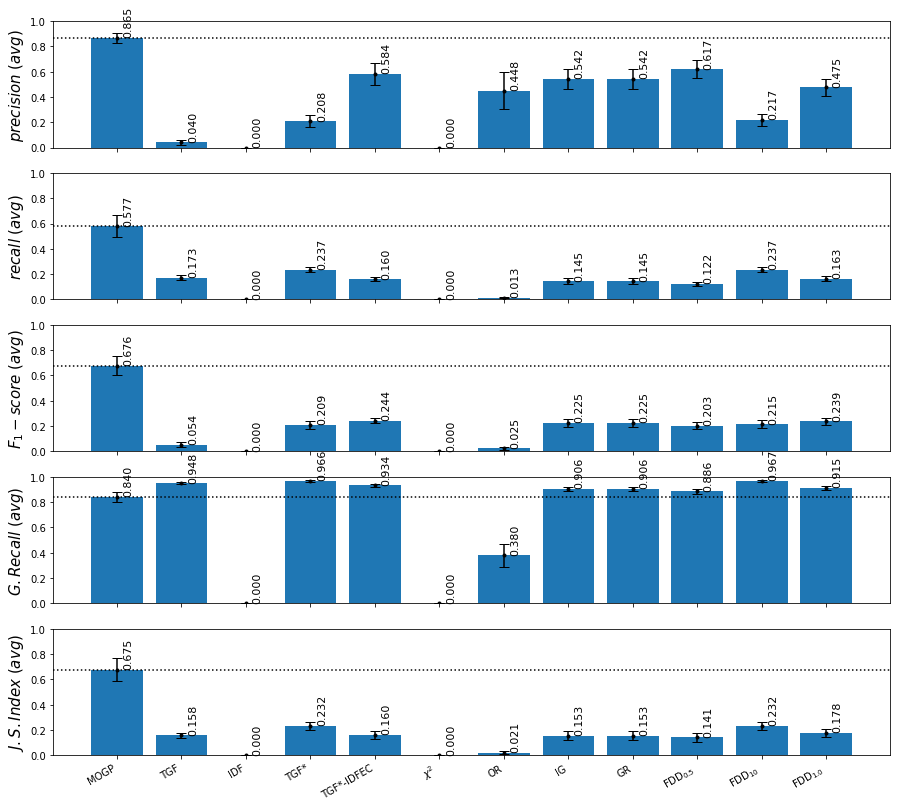

In [21]:
%matplotlib inline
import csv

!mkdir 'queries-CSVs'
    
# names ceci
names = ['MOGP','TGF', 'IDF', 'TGF*',   'TGF*-IDFEC', '$\chi^2$', 'OR','IG', 'GR',  r'FDD$_{0.5}$',r'FDD$_{10}$', r'FDD$_{1.0}$']

def tf(a,b,c,d):    
    return a + c
def tf_idf_ast(a,b,c,d):
	return tf(a,b,c,d)*idfec(a,b,c,d)
def tf_ast(a,b,c,d):
	return a

def tf_ast_idf_ast(a,b,c,d):
	return tf_ast(a,b,c,d) * idfec(a,b,c,d)#np.log10((c+d)/(c+eps))
def discr(a,b,c,d):
	solucion = np.zeros(shape=a.shape)
	mask = (a+c)!=0
	solucion[mask] = a[mask]/(a[mask]+c[mask])
	return solucion
	#return a/(a+c)
def descr(a,b,c,d):
	solucion = np.zeros(shape=a.shape)
	mask = (a+b)!=0
	solucion[(a+b)!=0] = a[mask]/(a[mask]+b[mask])
	return solucion

def fscore(a,b,c,d, alpha=0.82):
	di = discr(a,b,c,d)
	de = descr(a,b,c,d)
	beta = 1 - alpha
	return 2*((alpha*de*beta*di)/(eps+alpha*de+beta*di))


def delete_zeros(c):
	j = c.copy()
	j[j==0]=1
	return j

def prob_based(a,b,c,d):
	return np.log10(1+(a/b)*(a/(c+eps))) # fix delete_zeros

def gss(a,b,c,d):
    #checkeado Domeneconi
	N = a + b + c + d
	return (a*d - b*c)/(N**2)

def x_sqr(a,b,c,d):
	N = a + b + c + d
	num = (a*d - b*c) ** 2
	den = (a + c)* (b + d) * (a + b) * (c + d)
	return N / ((num/(den+eps))+eps)

def odds_ratio(a,b,c,d):
	return np.log10((delete_zeros(a)*d)/(b*c+eps))

def information_gain(a,b,c,d):
	N = a + b + c + d
	termino1 = -((a+b)/N)  * np.log10((a+b)/N)
	termino2 = (a / N) * np.log10((a+eps)/(a+c+eps))
	termino3 = (b/N) * np.log10((b+eps)/(b+d+eps))
	return (termino1 + termino2 + termino3)

def gain_ratio(a,b,c,d):
	N = a + b + c + d
	ig = information_gain(a,b,c,d)
	term1 = -((a+b)/N)*np.log10((a+b+eps)/N)
	term2 = -((c+d)/N)*np.log10((c+d+eps)/N)
	return ig/(term1+term2+eps)

def mutual_information(a,b,c,d):
	N = a + b + c + d
	return np.log10(  ((eps+a)*N)  /   (eps +(a+b) * (a+c))   )
def idf(a,b,c,d):
	N = a + b + c + d
	return np.log10(N/(a+c+eps))
def idf_prob(a,b,c,d):
	return np.log10((b+d+eps)/(a+c+eps))
def rf(a,b,c,d):
	return np.log10(2+(a/(c+eps) ) )

def idfec(a,b,c,d):
	return np.log10(  (eps+c+d)/  ((eps+c))  )

def idfec_b(a,b,c,d):
	return np.log10(2 + (  (a+c+d)   /   ((c+eps))  ))
 
def fdd_05(a,b,c,d):
    return  fdd(a,b,c,d,beta=0.5)
def fdd_10(a,b,c,d):
    return fdd(a,b,c,d,beta=10)

#ceci
def fdd_1(a,b,c,d):
    return fdd(a,b,c,d,beta=1.0)


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # #       IGM       # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# ESWA 2016
# Generally, the
# coefficient is set empirically to be 5.0 ∼ 9.0. The default value of λ
# is set to be 7.0
def igm(matriz, target, lambda_=7):
  cant_docs = matriz.shape[0]
  cant_terms = matriz.shape[1]
  assert target.shape == (cant_docs,1)

  igm_ = np.zeros(shape=(1,cant_terms))
  
  for term_idx in range(cant_terms):
    cant_categorias = len(set(target[:,0]))
    
#     print("cant_categorias", cant_categorias)
#     print("np.sum(target > cant_categorias) ", np.sum(target>cant_categorias))
#     print("target", target)

#    assert np.sum(target>cant_categorias)==0, 'Los indices de la categorias van\ desde cero hasta cant_categorias-1'
    f_kr = np.zeros(shape=(cant_categorias))
    for categoria in range(cant_categorias):
      freq = matriz[target[:,0]==categoria,term_idx]
      f_kr[categoria] = np.sum(freq)


    f_kr = np.sort(f_kr)[::-1]

    igm_[0,term_idx] = f_kr[0]/(np.sum(f_kr*np.arange(1,1+len(f_kr))))
      
  return 1 + lambda_ *  igm_


def tf_ast_igm(matrix,target, category):
  a, b, c, d = get_abcd(matrix,target==category)

#   print( "\n\nen tf_ast_igm llamare a tf_ast(a,b,c,d)")

#   tf_ast_ = tf_ast(a,b,c,d)
#   print(tf_ast_)
#   print("\n\nllamare a igm(matrix, target) con target =")
#   print(target, "\n\n")
    
  igm_ = igm(matrix, target)
  return tf_ast_*igm_
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # #    END IGM        # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # #       IGM_imp       # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


def igm_imp(matriz, target, lambda_=7):
  cant_docs = matriz.shape[0]
  cant_terms = matriz.shape[1]
  assert target.shape == (cant_docs,1)

  igm_imp_ = np.zeros(shape=(1,cant_terms))
  
  for term_idx in range(cant_terms):
    cant_categorias = len(set(target[:,0]))
#    assert np.sum(target>cant_categorias)==0, 'Los indices de la categorias van\ desde cero hasta cant_categorias-1'
    f_kr = np.zeros(shape=(cant_categorias))
    for categoria in range(cant_categorias):
      freq = matriz[target[:,0]==categoria,term_idx]
      f_kr[categoria] = np.sum(freq)


    doc_per_cat = np.array([np.sum(target[:,0]==cat) for cat in range(cant_categorias)])
    Dtotal = doc_per_cat[np.argsort(f_kr)[::-1][0]]



    f_kr = np.sort(f_kr)[::-1]

    f_k1 = f_kr[0]



    igm_imp_[0,term_idx] = f_kr[0]/(np.sum(f_kr*np.arange(1,1+len(f_kr))) + np.log10(Dtotal/f_k1))
      
  return 1 + lambda_ * igm_imp_

def tf_ast_igm_imp(matrix,target, category):
  a, b, c, d = get_abcd(matrix,target==category)
  tf_ast_ = tf_ast(a,b,c,d)
  igm_imp_ = igm_imp(matrix, target)
  return tf_ast_*igm_imp_

def sqrt_tf_ast_igm_imp(matrix,target, category):
  a, b, c, d = get_abcd(matrix,target==category)
  tf_ast_ = tf_ast(a,b,c,d)
  igm_imp_ = igm_imp(matrix, target)
  return np.sqrt(tf_ast_)*igm_imp_

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # #       end IGM_imp       # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


def MOGP(a,b,c,d):
    
    # a denotes the number of documents that belong to class c_k and contain term t_i
    solucion = np.zeros(shape=a.shape)    
    return solucion
    

def get_GR_JIS_MOGP(topic_id):
    
    ## abrir CSV y devolver para GR la fila de promedios para todas las 5 corridas del topicId - es la ultima columna
    ## idem JIS

    # CSV:
    # Topic_number  Run_1  Run_2  Run_3  Run_4  Run_5
    #          1     0.96     1.00     1.00     0.94 
    #         134    1.00     0.86     0.96     0.94 
    #         ... 

    root = 'MOGP/'
    file = 'Co3_globalRecall_allRun_lastGen_per_topic_TRAINING.csv'
    
    # GR LAST GEN - MEAN ALL RUN
    df_GR = pd.read_csv(os.path.join(root, file), header=[0]).iloc[:, 1:] #el ultimo iloc elimina primer columna que son indices anteriores
    gr_topicId = df_GR.loc[df_GR['Topic_number'] == topic_id]    
    GR = gr_topicId["mean"]
    
    
    file = 'Co3_JaccardIndex_allRun_lastGen_per_topic_TRAINING.csv'
    
    # GR LAST GEN - MEAN ALL RUN
    df_JIS = pd.read_csv(os.path.join(root, file), header=[0]).iloc[:, 1:] #el ultimo iloc elimina primer columna que son indices anteriores
    jis_topicId = df_JIS.loc[df_JIS['Topic_number'] == topic_id]
    JIS = jis_topicId["mean"]
    

    return float(GR), float(JIS)

def get_GR_JIS_MOGP_testing(topic_id):
    
    ## abrir CSV y devolver para GR la fila de promedios para todas las 5 corridas del topicId - es la ultima columna
    ## idem JIS

    # CSV:
    # Topic_number  Run_1  Run_2  Run_3  Run_4  Run_5
    #          1     0.96     1.00     1.00     0.94 
    #         134    1.00     0.86     0.96     0.94 
    #         ... 

    root = 'MOGP/'
    file = 'Co3_MEAN_GLOBAL_RECALL_FROM_TESTING_ALL_TOPICS_LAST_GEN_ordered.csv'
    
    # GR LAST GEN - MEAN ALL RUN
    df_GR = pd.read_csv(os.path.join(root, file), header=[0]).iloc[:, 1:] #el ultimo iloc elimina primer columna que son indices anteriores
    gr_topicId = df_GR.loc[df_GR['Topic_number'] == topic_id]    
    GR = gr_topicId["mean"]
    
    file = 'Co3_MEAN_JACCARD_SIM_FROM_TESTING_ALL_TOPICS_LAST_GEN_ordered.csv'
    
    # GR LAST GEN - MEAN ALL RUN
    df_JIS = pd.read_csv(os.path.join(root, file), header=[0]).iloc[:, 1:] #el ultimo iloc elimina primer columna que son indices anteriores
    jis_topicId = df_JIS.loc[df_JIS['Topic_number'] == topic_id]
    JIS = jis_topicId["mean"]
    

    return float(GR), float(JIS)

        
def getPrecisionRecallMOGP(topic_id):

    ## abrir CSV y devolver para precision la fila de promedios para todas las 5 corridas del topicId
    ## idem Recall

    # CSV:
    # Topic_number  query_0  query_1  query_2  query_3  query_4  query_5  ... query_99
    #          1     0.96     1.00     1.00     0.94     0.94     0.90          0.915
    #         134    1.00     0.86     0.96     0.94     1.00     0.92          0.86
    #         ... 

    root = 'MOGP/'
    file = 'Co3_precision_allRun_lastGen_per_topic_TRAINING.csv'

    # PRECISION LAST GEN - MEAN ALL RUN
    df_P = pd.read_csv(os.path.join(root, file), header=[0]).iloc[:, 1:] #el ultimo iloc elimina primer columna que son indices anteriores

    precision_topicId = df_P.loc[df_P['Topic_number'] == topic_id]
    precision_topicId = precision_topicId.drop('Topic_number', 1) # elimina el numero de topico - devuelve arreglo limpio de promedios


    file = 'Co3_recall_allRun_lastGen_per_topic_TRAINING.csv'
    
    # RECALL LAST GEN - MEAN ALL RUN
    df_R = pd.read_csv(os.path.join(root, file), header=[0]).iloc[:, 1:] #el ultimo iloc elimina primer columna que son indices anteriores

    recall_topicId = df_R.loc[df_R['Topic_number'] == topic_id]
    recall_topicId = recall_topicId.drop('Topic_number', 1) # elimina el numero de topico - devuelve arreglo limpio de promedios

    return precision_topicId.to_numpy(), recall_topicId.to_numpy()

def getPrecisionRecallMOGP_testing(topic_id):

    ## abrir CSV y devolver para precision la fila de promedios para todas las 5 corridas del topicId
    ## idem Recall

    # CSV:
    # Topic_number  query_0  query_1  query_2  query_3  query_4  query_5  ... query_99
    #          1     0.96     1.00     1.00     0.94     0.94     0.90          0.915
    #         134    1.00     0.86     0.96     0.94     1.00     0.92          0.86
    #         ... 

    root = 'MOGP/'
    file = 'Co3_MEAN_PRECISION@10_FROM_TESTING_ALL_TOPICS_LAST_GEN_ordered.csv'

    # PRECISION LAST GEN - MEAN ALL RUN
    df_P = pd.read_csv(os.path.join(root, file), header=[0]).iloc[:, 1:] #el ultimo iloc elimina primer columna que son indices anteriores

    precision_topicId = df_P.loc[df_P['Topic_number'] == topic_id]
    precision_topicId = precision_topicId.drop('Topic_number', 1) # elimina el numero de topico - devuelve arreglo limpio de promedios

    precision_topicId = precision_topicId["mean"]
    
    
    # EL RECALL esta almacenado como
    # topic number  mean all run
    #      1           0.703889
    #      134         0.874884
    ######
    
    
    file = 'Co3_RECALL_FROM_TESTING_ALL_TOPICS_LAST_GEN_ordered.csv'
    
    # RECALL LAST GEN - MEAN ALL RUN
    df_R = pd.read_csv(os.path.join(root, file), header=[0]).iloc[:, 1:] #el ultimo iloc elimina primer columna que son indices anteriores    
    recall_topicId = df_R.loc[df_R['Topic_number'] == topic_id]
    recall_topicId = recall_topicId.drop('Topic_number', 1) # elimina el numero de topico - devuelve arreglo limpio de promedios
    
    return precision_topicId.to_numpy(), recall_topicId.to_numpy()

# metodos ceci
methods = [MOGP, tf, idf, tf_ast, tf_ast_idf_ast, x_sqr, odds_ratio, information_gain, gain_ratio, fdd_05, fdd_10, fdd_1]


# usados por Maiso
#methods = [tf, idf, tf_ast,tf_ast_idf_ast , x_sqr, odds_ratio,tf_ast_igm,  information_gain, gain_ratio, tf_ast_igm_imp, gss, prob_based, sqrt_tf_ast_igm_imp,rf, idfec, tf_idf_ast, mutual_information , idfec_b, fdd_05,fdd_10]


#testing = False

topic_names = []
#print(topics)
for cat in topics:
    topic_name = dict_topic_numb_name[cat]['topic_name']
    topic_name = topic_name.replace("/", "-")  
    topic_names.append(topic_name)
    print(topic_name)
print("----------------------------------------------------------------- \n\n")    


categ2index = dict([(cat,idx) for idx,cat in enumerate(topic_names)])
index2categ = dict([(idx,cat) for idx,cat in enumerate(topic_names)])

# matrix to store metrics from training
recalls = np.zeros(shape=(len(categ2index),len(methods)))   
precisions = np.zeros((len(categ2index),len(methods))) 
f1_score = np.zeros(shape=(len(categ2index),len(methods)))
globalRecalls = np.zeros(shape=(len(categ2index),len(methods)))
jaccardIndexes = np.zeros(shape=(len(categ2index),len(methods)))

# matrix to store metrics from testing
recalls_testing = np.zeros(shape=(len(categ2index),len(methods)))
precisions_testing = np.zeros((len(categ2index),len(methods)))
f1_score_testing = np.zeros(shape=(len(categ2index),len(methods)))
globalRecalls_testing = np.zeros(shape=(len(categ2index),len(methods)))
jaccardIndexes_testing = np.zeros(shape=(len(categ2index),len(methods)))


# RECALL:
#            FDD     TGF     TGF*
# cat 1      x.xx    x.xx   x.xx
# cat 2      x.xx    x.xx   x.xx
# cat 3      x.xx    x.xx   x.xx
# cat 4      x.xx    x.xx   x.xx

# precision:
#            FDD     TGF     TGF*
# cat 1      x.xx    x.xx   x.xx
# cat 2      x.xx    x.xx   x.xx
# cat 3      x.xx    x.xx   x.xx
# cat 4      x.xx    x.xx   x.xx


i = np.array(vocab)


for idx, category in enumerate(topics):            ##################################### CECI
    t_testing = Texto.target(test, category_idx=category)
    t_training = Texto.target(train, category_idx=category)   # vector de T o F si el doc es relev para el topico o no
    
    #     A = [i for i, x in enumerate(t_training) if x]
    #     print("las posiciones de docus relevantes para el topico ", category)
    #     print (A)

    print("\n\n")
    print("TOPICO = ", category)
    
    # almacena un csv por topico, con las 100 queries de cada metodo
    writer = open('queries-CSVs/{}_queries.csv'.format(category), "w")

    a, b, c, d = get_abcd(m_train,t_training)   

    a_testing, b_testing, c_testing, d_testing = get_abcd(m_test,t_testing)
    
    recall = descr(a,b,c,d)
    precision = discr(a,b,c,d)
    
    recall_testing = descr(a_testing, b_testing, c_testing, d_testing)
    precision_testing = discr(a_testing, b_testing ,c_testing , d_testing)
    
    f = open('queries-CSVs/{}_queries.csv'.format(category), "w")
    
    # create the csv writer
    writer = csv.writer(f)
    
    header = ["method"] + ["query_"+str(i) for i in range(0,100)]
    writer.writerow(header)
    
    for k in range(len(methods)):
    
        method = methods[k]
        
        print("topico= ", category, " - Metodo= ", method.__name__)        
        
        sum_recall_value = 0.0
        sum_recall_value_testing = 0.0
        
        sum_prec_value = 0.0
        sum_prec_value_testing = 0.0                     
        
        gr_per_method = 0.0
        gr_per_method_testing = 0.0
        
        jis_per_method = 0.0
        jis_per_method_testing = 0.0
        
        queries_method_k = []        
        
        if method.__name__ == "MOGP":
            # los valores de las metricas de MOGP ya estan calculados en CSVs
            precisions_topicId, recalls_topicId = getPrecisionRecallMOGP(int(category))
            precisions_topicId_testing, recalls_topicId_testing = getPrecisionRecallMOGP_testing(int(category))
            
            sum_prec_value = np.sum(precisions_topicId)
            sum_prec_value_testing = np.sum(precisions_topicId_testing)
            
            sum_recall_value = np.sum(recalls_topicId)
            sum_recall_value_testing = np.sum(recalls_topicId_testing)           
            
            
        else:
            
            best_100_words_with_k, scores_with_k = get_best_word_method(m_train, Texto.target(train), category, vocab, method)
            print(scores_with_k) 
            
            total_RR = []
            RR1 = []
            
            total_RR_testing = []
            RR2 = []
            
            for indx in range(1, len(best_100_words_with_k)+1):                            
                
                index_topword = scores_with_k[-1*indx]                        
                                   
                #top_word = (i[np.argsort(scores_with_k)])[-1][-1*indx]
                top_word = (i[index_topword])
                
                queries_method_k.append(top_word)

                # estan comentados F1 ya se calculan aparte. comprobado que da igual
                #RR: relevantes_recuperados por cada termino-vectores de Bool - tantas filas como docus en train o test
                precision_value, recall_value , _ , RR1 = get_ir_metrics(top_word, m_train, m_tfIdf_train, Texto.target(train), category, vocab)
                
                sum_recall_value+= recall_value
                sum_prec_value+= precision_value
                
                
                # total de Relevantes Recuperados para GR en TRAIN
                if len(total_RR)==0:
                    total_RR = RR1
                else:            
                    total_RR = (total_RR | RR1)            
                #print("termino= ", top_word, " total_RR \t" ,np.sum(total_RR) )
                
                
                
                # metricas para TESTING
                precision_value_testing, recall_value_testing , f1_value_testing, RR2 = get_ir_metrics(top_word, m_test, m_tfIdf_test, Texto.target(test), category, vocab)                                                                    
                
                # total de Relevantes Recuperados para GR en TEST
                if len(total_RR_testing)==0:
                    total_RR_testing = RR2
                else:            
                    total_RR_testing = (total_RR_testing | RR2)                      
                #print("termino= ", top_word, " total_RR_TESTING \t" ,np.sum(total_RR_testing) )                    

                sum_recall_value_testing+= recall_value_testing
                sum_prec_value_testing+= precision_value_testing
                
                top_word = None
                
            
            #almaceno las queries en CSVs segun el metodo                
            line = [method.__name__] + queries_method_k

            writer.writerow(line)
            

            gr_per_method, jis_per_method = get_ir_poblational_metrics(queries_method_k, m_train, total_RR, Texto.target(train), category, vocab)
            gr_per_method_testing, jis_per_method_testing = get_ir_poblational_metrics(queries_method_k, m_test, total_RR_testing, Texto.target(test), category, vocab)
        
        if method.__name__ == "MOGP":
            #print ("mean RECALL ", sum_recall_value/100)
            #print ("mean PRECISION ", sum_prec_value/100)
            
            recalls[idx,k] = sum_recall_value/100
            precisions[idx,k] = sum_prec_value/100             # CON MOGP SON 100 queries
            globalRecalls[idx,k], jaccardIndexes[idx,k] = get_GR_JIS_MOGP(int(category))                 # TERMINAR  TERMINAR  TERMINAR  TERMINAR  TERMINAR  TERMINAR  TERMINAR  TERMINAR  TERMINAR  TERMINAR  TERMINAR  TERMINAR  TERMINAR  TERMINAR  TERMINAR   
            
            recalls_testing[idx,k] = sum_recall_value_testing
            precisions_testing[idx,k] = sum_prec_value_testing             # YA SON PROMEDIOS
            globalRecalls_testing[idx,k], jaccardIndexes_testing[idx,k] = get_GR_JIS_MOGP_testing(int(category))

            
        else:
            
            recalls[idx,k] = sum_recall_value/len(best_100_words_with_k)
            recalls_testing[idx,k] = sum_recall_value_testing/len(best_100_words_with_k)
            
            precisions[idx,k] = sum_prec_value/len(best_100_words_with_k)
            precisions_testing[idx,k] = sum_prec_value_testing/len(best_100_words_with_k)
            
            globalRecalls[idx,k] = gr_per_method
            globalRecalls_testing[idx,k] = gr_per_method_testing
            
            jaccardIndexes[idx,k] = jis_per_method
            jaccardIndexes_testing[idx,k] = jis_per_method_testing
                                                   
            
            

    # se queda con una top word en RECALL y otra en PREC para cada topico - WHY? creo que no se usa
    top_word_r = (i[np.argsort(recall)])[-1][-1]
    top_word_p = (i[np.argsort(precision)])[-1][-1]
    
    f.close()

from scipy.stats import sem, t
from scipy import mean

import matplotlib.pyplot as plt

# testing = False

confidence = 0.95

# promedia metricas por TODOS LOS TOPICOS
r = np.average(recalls,axis=0)
p = np.average(precisions,axis=0)
f1scores = np.zeros(shape=(len(categ2index),len(methods)))
mask = (precisions+recalls)!=0
f1scores[mask] = 2.0 * ((precisions[mask] * recalls[mask]) / (precisions[mask]+recalls[mask]))
f1 = np.average(f1scores,axis=0)

gr = np.average(globalRecalls,axis=0)
jis = np.average(jaccardIndexes,axis=0)

deltas_f1score = np.zeros(shape=(len(methods)))
deltas_recall = np.zeros(shape=(len(methods)))
deltas_precision = np.zeros(shape=(len(methods)))
deltas_gr = np.zeros(shape=(len(methods)))
deltas_jis = np.zeros(shape=(len(methods)))

for columna in range(len(recalls[0,:])):
    datos = recalls[:,columna]
    n = len(datos)
    std_err = sem(datos)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    deltas_recall[columna] = h
    
    datos = precisions[:,columna]
    n = len(datos)
    std_err = sem(datos)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    deltas_precision[columna] = h
    
    datos = f1scores[:,columna]
    n = len(datos)
    std_err = sem(datos)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    deltas_f1score[columna] = h
    
    # NUEVO GR Y JIS
    datos = globalRecalls[:,columna]
    n = len(datos)
    std_err = sem(datos)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    deltas_gr[columna] = h
    
    datos = jaccardIndexes[:,columna]
    n = len(datos)
    std_err = sem(datos)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    deltas_jis[columna] = h

#for cate in range(len(methods)):
#    print('method: {:15} recall: {:5,.4f} precision {:5,.4f} f1-score: {:5,.4f}'.format(names[cate],r[cate],p[cate],f1[cate]))
#print('method: {:15} recall: {:5,.4f} precision {:5,.4f} f1-score: {:5,.4f}'.format('FDD',r[cate+1],p[cate+1],f1[cate+1]))
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 15]
fig,ax = plt.subplots(5)


## PLOT PRECISION
label = [f'{value:4.3f}' for value in p]
for i in range(len(p)):
  ax[0].text(x =i+0.1 , y = p[i]+0.02, s = label[i], size = 11, rotation=90)

ax[0].bar(np.arange(len(methods)), height=p,tick_label=names)
ax[0].errorbar(np.arange(len(methods)),p,yerr=deltas_precision,fmt='.k',capsize=5)

## PLOT RECALL
label = [f'{value:4.3f}' for value in r]
for i in range(len(r)):
  ax[1].text(x =i+0.1 , y = r[i]+0.02, s = label[i], size = 11, rotation=90)

ax[1].bar(np.arange(len(methods)), height=r,tick_label=names)
ax[1].errorbar(np.arange(len(methods)),r,yerr=deltas_recall,fmt='.k',capsize=5)

## PLOT F1
label = [f'{value:4.3f}' for value in f1]
for i in range(len(f1)):  
  ax[2].text(x =i+0.1 , y = f1[i]+0.02, s = label[i], size = 11, rotation=90)

ax[2].bar(np.arange(len(methods)), height=f1,tick_label=names)
ax[2].errorbar(np.arange(len(methods)),f1,yerr=deltas_f1score,fmt='.k',capsize=5)

## PLOT GLOBAL RECALL
label = [f'{value:4.3f}' for value in gr]
for i in range(len(gr)):  
  ax[3].text(x =i+0.1 , y = gr[i]+0.02, s = label[i], size = 11, rotation=90)

ax[3].bar(np.arange(len(methods)), height = gr,tick_label=names)
ax[3].errorbar(np.arange(len(methods)),gr,yerr=deltas_gr,fmt='.k',capsize=5)

## PLOT JACCARD INDEX SIM
label = [f'{value:4.3f}' for value in jis]
for i in range(len(jis)):  
  ax[4].text(x =i+0.1 , y = jis[i]+0.02, s = label[i], size = 11, rotation=90)

ax[4].bar(np.arange(len(methods)), height= jis ,tick_label=names)
ax[4].errorbar(np.arange(len(methods)),jis,yerr=deltas_jis,fmt='.k',capsize=5)




ax[1].set_ylabel('$recall$ $(avg)$',fontsize=15)
ax[0].set_ylabel('$precision$ $(avg)$',fontsize=15)
ax[2].set_ylabel('$F_1-score$ $(avg)$',fontsize=15)
ax[3].set_ylabel('$G. Recall$ $(avg)$',fontsize=15)
ax[4].set_ylabel('$J. S. Index$ $(avg)$',fontsize=15)


ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)
ax[2].set_ylim(0,1)
ax[3].set_ylim(0,1)
ax[4].set_ylim(0,1)


for plot in ax:

    for tick in plot.xaxis.get_major_ticks():
        tick.label.set_fontsize(10) 
    for tick in plot.yaxis.get_major_ticks():
        tick.label.set_fontsize(10) 

fig.autofmt_xdate()



# horizontal line in MOGP value
ax[0].axhline(y=p[-12], c='k',ls=':')
ax[1].axhline(y=r[-12], c='k',ls=':')
ax[2].axhline(y=f1[-12], c='k',ls=':')
ax[3].axhline(y=gr[-12], c='k',ls=':')
ax[4].axhline(y=jis[-12], c='k',ls=':')

#fig.savefig(f'performanceComparisonDMOZ{"Testing" if testing else "Training"}.pdf')
fig.savefig(f'performanceComparisonDMOZ_Training.pdf')

## PLOT TESTING
**Results ofthe queries generated avobe but over a new data set** (using the testing matrices)

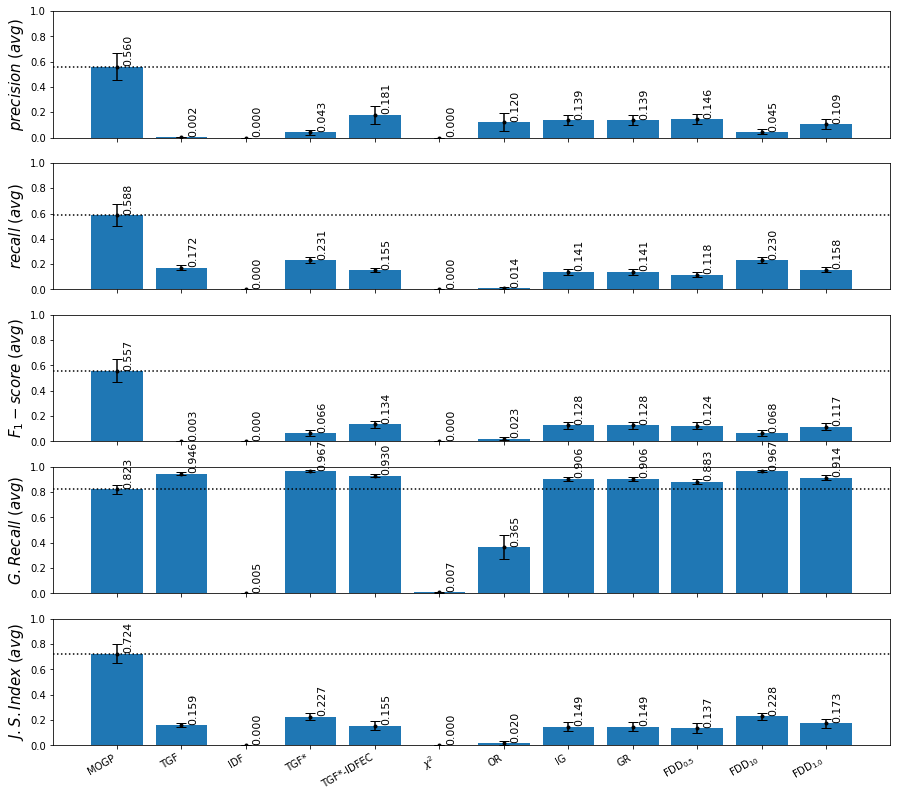

In [22]:

# renombro a nombres usados en plot de mas arriba para no introducir bugs, ya que el calculo es el mismo
recalls = recalls_testing
precisions = precisions_testing
globalRecalls = globalRecalls_testing
jaccardIndexes = jaccardIndexes_testing

# promedia metricas por TODOS LOS TOPICOS
r = np.average(recalls,axis=0)
p = np.average(precisions,axis=0)
f1scores = np.zeros(shape=(len(categ2index),len(methods)))
mask = (precisions+recalls)!=0
f1scores[mask] = 2.0 * ((precisions[mask] * recalls[mask]) / (precisions[mask]+recalls[mask]))
f1 = np.average(f1scores,axis=0)

gr = np.average(globalRecalls,axis=0)
jis = np.average(jaccardIndexes,axis=0)

deltas_f1score = np.zeros(shape=(len(methods)))
deltas_recall = np.zeros(shape=(len(methods)))
deltas_precision = np.zeros(shape=(len(methods)))
deltas_gr = np.zeros(shape=(len(methods)))
deltas_jis = np.zeros(shape=(len(methods)))

for columna in range(len(recalls[0,:])):
    datos = recalls[:,columna]
    n = len(datos)
    std_err = sem(datos)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    deltas_recall[columna] = h
    
    datos = precisions[:,columna]
    n = len(datos)
    std_err = sem(datos)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    deltas_precision[columna] = h
    
    datos = f1scores[:,columna]
    n = len(datos)
    std_err = sem(datos)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    deltas_f1score[columna] = h
    
    # NUEVO GR Y JIS
    datos = globalRecalls[:,columna]
    n = len(datos)
    std_err = sem(datos)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    deltas_gr[columna] = h
    
    datos = jaccardIndexes[:,columna]
    n = len(datos)
    std_err = sem(datos)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    deltas_jis[columna] = h

#for cate in range(len(methods)):
#    print('method: {:15} recall: {:5,.4f} precision {:5,.4f} f1-score: {:5,.4f}'.format(names[cate],r[cate],p[cate],f1[cate]))
#print('method: {:15} recall: {:5,.4f} precision {:5,.4f} f1-score: {:5,.4f}'.format('FDD',r[cate+1],p[cate+1],f1[cate+1]))
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 15]
fig,ax = plt.subplots(5)


## PLOT PRECISION
label = [f'{value:4.3f}' for value in p]
for i in range(len(p)):
  ax[0].text(x =i+0.1 , y = p[i]+0.02, s = label[i], size = 11, rotation=90)

ax[0].bar(np.arange(len(methods)), height=p,tick_label=names)
ax[0].errorbar(np.arange(len(methods)),p,yerr=deltas_precision,fmt='.k',capsize=5)

## PLOT RECALL
label = [f'{value:4.3f}' for value in r]
for i in range(len(r)):
  ax[1].text(x =i+0.1 , y = r[i]+0.02, s = label[i], size = 11, rotation=90)

ax[1].bar(np.arange(len(methods)), height=r,tick_label=names)
ax[1].errorbar(np.arange(len(methods)),r,yerr=deltas_recall,fmt='.k',capsize=5)

## PLOT F1
label = [f'{value:4.3f}' for value in f1]
for i in range(len(f1)):  
  ax[2].text(x =i+0.1 , y = f1[i]+0.02, s = label[i], size = 11, rotation=90)

ax[2].bar(np.arange(len(methods)), height=f1,tick_label=names)
ax[2].errorbar(np.arange(len(methods)),f1,yerr=deltas_f1score,fmt='.k',capsize=5)

## PLOT GLOBAL RECALL
label = [f'{value:4.3f}' for value in gr]
for i in range(len(gr)):  
  ax[3].text(x =i+0.1 , y = gr[i]+0.02, s = label[i], size = 11, rotation=90)

ax[3].bar(np.arange(len(methods)), height = gr,tick_label=names)
ax[3].errorbar(np.arange(len(methods)),gr,yerr=deltas_gr,fmt='.k',capsize=5)

## PLOT JACCARD INDEX SIM
label = [f'{value:4.3f}' for value in jis]
for i in range(len(jis)):  
  ax[4].text(x =i+0.1 , y = jis[i]+0.02, s = label[i], size = 11, rotation=90)

ax[4].bar(np.arange(len(methods)), height= jis ,tick_label=names)
ax[4].errorbar(np.arange(len(methods)),jis,yerr=deltas_jis,fmt='.k',capsize=5)




ax[1].set_ylabel('$recall$ $(avg)$',fontsize=15)
ax[0].set_ylabel('$precision$ $(avg)$',fontsize=15)
ax[2].set_ylabel('$F_1-score$ $(avg)$',fontsize=15)
ax[3].set_ylabel('$G. Recall$ $(avg)$',fontsize=15)
ax[4].set_ylabel('$J. S. Index$ $(avg)$',fontsize=15)


ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)
ax[2].set_ylim(0,1)
ax[3].set_ylim(0,1)
ax[4].set_ylim(0,1)

for plot in ax:

    for tick in plot.xaxis.get_major_ticks():
        tick.label.set_fontsize(10) 
    for tick in plot.yaxis.get_major_ticks():
        tick.label.set_fontsize(10) 

fig.autofmt_xdate()



# horizontal line in MOGP value
ax[0].axhline(y=p[-12], c='k',ls=':')
ax[1].axhline(y=r[-12], c='k',ls=':')
ax[2].axhline(y=f1[-12], c='k',ls=':')
ax[3].axhline(y=gr[-12], c='k',ls=':')
ax[4].axhline(y=jis[-12], c='k',ls=':')

fig.savefig(f'performanceComparisonDMOZ_Testing.pdf')